# 手写数字识别

## 准备数据集

In [1]:
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
from paddle.vision.transforms import Normalize
import paddle.nn.functional as F
import numpy as np
import os

In [2]:
# 下载数据集并初始化，导入训练和测试数据集,并对数据进行处理
transform = Normalize(mean=[127.5], std=[127.5])

train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

读取训练数据集中数据内容，绘制数据：

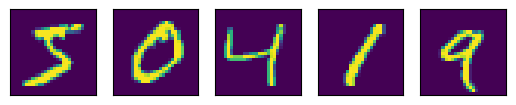

In [3]:
data_loader = paddle.io.DataLoader(train_dataset,batch_size=100)
train_data = enumerate(data_loader())
idx,(data,label) = next(train_data)

import matplotlib.pyplot as plt

# 绘制一些数据集图像
plt.figure()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(data[i][0])
    plt.xticks([]),plt.yticks([])


## 模型网络设计

In [3]:
# 定义模型结构
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
        super(MNIST, self).__init__()

        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        # 定义一层全连接层，输出维度是10
        self.fc = Linear(in_features=980, out_features=10)
        
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs, label=None):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc(x)
        if label is not None:
            acc = paddle.metric.accuracy(input=x, label=label)
            return x, acc
        else:
            return x

## 模型训练

In [4]:
def train(model):
    model.train()
    
    # 调用加载数据的函数，设置mini-batch 中样本个数为100，设置shuffle=True打乱顺序
    train_loader = paddle.io.DataLoader(train_dataset, batch_size=100, shuffle=True)
    
    # 四种优化算法的设置方案，可以逐一尝试效果
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    
    EPOCH_NUM = 10
    iter=0
    iters=[]
    losses=[]
    
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            # 准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            # 前向计算的过程,同时计算分类准确率
            predicts, acc = model(images, labels)
            #predicts = model(images)
            
            # 计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            # 每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 100 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.item(), acc.item()))
                iters.append(iter)
                losses.append(avg_loss.item())
                iter = iter + 100
                
            # 后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    # 保存模型参数
    paddle.save(model.state_dict(), './paddle/mnist.pdparams')
    
    return iters, losses
    
# 创建模型    
model = MNIST()

#paddle.summary(model, (1, 1, 28, 28))

# 启动训练过程
#开启GPU
#use_gpu = True
#paddle.device.set_device('gpu:0') if use_gpu else paddle.device.set_device('cpu')
iters, losses = train(model)


epoch: 0, batch: 0, loss is: 3.1040005683898926, acc is 0.09000000357627869
epoch: 0, batch: 100, loss is: 0.408119797706604, acc is 0.8700000047683716
epoch: 0, batch: 200, loss is: 0.345382422208786, acc is 0.8999999761581421
epoch: 0, batch: 300, loss is: 0.27586910128593445, acc is 0.8999999761581421
epoch: 0, batch: 400, loss is: 0.3045397102832794, acc is 0.8899999856948853
epoch: 0, batch: 500, loss is: 0.3037496507167816, acc is 0.9100000262260437
epoch: 1, batch: 0, loss is: 0.14953503012657166, acc is 0.9700000286102295
epoch: 1, batch: 100, loss is: 0.15108387172222137, acc is 0.9599999785423279
epoch: 1, batch: 200, loss is: 0.12093234807252884, acc is 0.9700000286102295
epoch: 1, batch: 300, loss is: 0.0649615004658699, acc is 0.9900000095367432
epoch: 1, batch: 400, loss is: 0.12195736169815063, acc is 0.9800000190734863
epoch: 1, batch: 500, loss is: 0.1105581745505333, acc is 0.949999988079071
epoch: 2, batch: 0, loss is: 0.054088104516267776, acc is 0.9800000190734863


In [10]:
# 打印输出网络结构
paddle.summary(model,(1,1,28,28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-3       [[1, 1, 28, 28]]     [1, 20, 28, 28]          520      
  MaxPool2D-3    [[1, 20, 28, 28]]     [1, 20, 14, 14]           0       
   Conv2D-4      [[1, 20, 14, 14]]     [1, 20, 14, 14]        10,020     
  MaxPool2D-4    [[1, 20, 14, 14]]      [1, 20, 7, 7]            0       
   Linear-2          [[1, 980]]            [1, 10]             9,810     
Total params: 20,350
Trainable params: 20,350
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.08
Estimated Total Size (MB): 0.27
---------------------------------------------------------------------------



{'total_params': 20350, 'trainable_params': 20350}

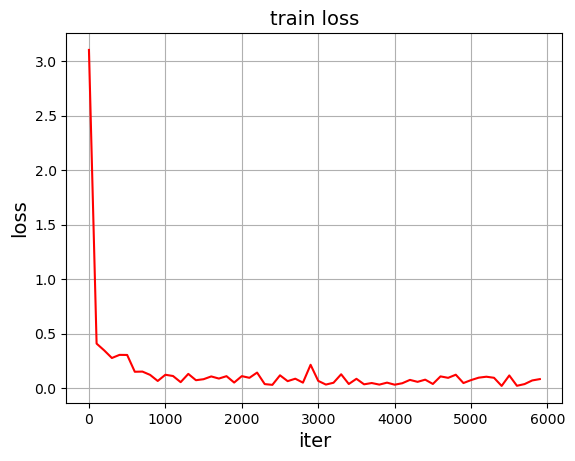

In [5]:
import matplotlib.pyplot as plt

# 画出训练过程中Loss的变化曲线
plt.figure()
plt.title("train loss", fontsize=14)
plt.xlabel("iter", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.plot(iters, losses,color='red') 
plt.grid()
plt.show()

## 模型测试

In [18]:
# 定义模型评估
def evaluation(model):
    params_file_path = './paddle/mnist.pdparams'
    # 加载模型参数
    print('loading mnist model from ', params_file_path)
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = paddle.io.DataLoader(test_dataset)

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.item()))
        avg_loss_set.append(float(avg_loss.item()))
    
    # 计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

# 模型评估
model = MNIST()
evaluation(model)


loading mnist model from  ./paddle/mnist.pdparams
loss=0.05035130242863519, acc=0.9844


In [7]:
# 需要保存的路径，当前onnx目录下
save_path = 'onnx/handwritten'
# 为模型指定输入的形状和数据类型
x_spec = paddle.static.InputSpec([1, 1, 28, 28], 'float32', 'x')
# 生成ONNX模型
paddle.onnx.export(model, save_path, input_spec=[x_spec], opset_version=11)

2023-09-11 09:03:22 [INFO]	Static PaddlePaddle model saved in onnx/paddle_model_static_onnx_temp_dir.
[Paddle2ONNX] Start to parse PaddlePaddle model...
[Paddle2ONNX] Model file path: onnx/paddle_model_static_onnx_temp_dir/model.pdmodel
[Paddle2ONNX] Paramters file path: onnx/paddle_model_static_onnx_temp_dir/model.pdiparams
[Paddle2ONNX] Start to parsing Paddle model...
[Paddle2ONNX] Use opset_version = 11 for ONNX export.
[Paddle2ONNX] PaddlePaddle model is exported as ONNX format now.
2023-09-11 09:03:22 [INFO]	ONNX model saved in onnx/handwritten.onnx.


I0911 09:03:22.786718 10495 interpretercore.cc:237] New Executor is Running.
